This notebook modify from :

Inference : https://github.com/Prim9000/tacotron2/blob/master/ThaiTTS_Inference.ipynb

Train : https://github.com/Prim9000/Thai_TTS/blob/main/Thai_TTS_Training.ipynb

# Extracting the Dataset

In [1]:
import os
import shutil
def download():
    url = "https://github.com/korakot/corpus/releases/download/v1.0/AIFORTHAI-TSync2Corpus.zip"
    print("NECTEC licensed TSync2 under CC-BY-NC-SA")
    print("Start downloading: .. ")
    os.system(f"wget {url}")
    os.system("unzip AIFORTHAI-TSync2Corpus.zip")
    os.system("rm AIFORTHAI-TSync2Corpus.zip")
    print("Finished")

In [3]:
download()

# Trim silence sampling rate = 220505

In [ ]:
import matplotlib.pyplot as plt
import os
import librosa
import shutil
import soundfile as sf
from tqdm.auto import tqdm

In [10]:
def trim(directory, filename, sr=22050, threshold=20):
  new_filename = "{}.wav".format(filename[:-4])
  signal, sr = librosa.load(os.path.join(directory,filename), sr=sr)
  trimed, index = librosa.effects.trim(signal, top_db=threshold)
  sf.write(os.path.join(directory, new_filename), trimed, samplerate=sr)
  shutil.move(os.path.join(directory, new_filename) , os.path.join('./TSync2/wav', new_filename))

In [9]:
len(os.listdir('./TSync2/wav'))

2710

In [11]:
source = './TSync2/wav'
# c = 0
for root, dirnames, filenames in os.walk(source):
    for filename in filenames:
      try:
        trim(source,filename)
        # c = c+1
        # print(c)
      except:
        pass

# Tacotron2

In [12]:
# %cd /content/

In [ ]:
%tensorflow_version 1.x
import os
from os.path import exists, join, basename, splitext
git_repo_url = 'https://github.com/Prim9000/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  !cd {project_name}/waveglow && git checkout 9168aea
  !pip install -q librosa unidecode

import sys
sys.path.append(join(project_name, 'waveglow/'))
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

TensorFlow 1.x selected.
Previous HEAD position was 5bc2a53 README.md: reporting correct number after finding bug in inference time code
HEAD is now at 9168aea README.md: layout
     |████████████████████████████████| 235 kB 14.2 MB/s 


In [ ]:
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

tacotron2_pretrained_model = 'tacotron2_statedict.pt'
if not exists(tacotron2_pretrained_model):
  # download the Tacotron2 pretrained model
  download_from_google_drive('1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA', tacotron2_pretrained_model)
waveglow_pretrained_model = 'waveglow_old.pt'
if not exists(waveglow_pretrained_model):
  # download the Waveglow pretrained model
  download_from_google_drive('1WsibBTsuRg_SF2Z6L6NFRTT-NjEy1oTx', waveglow_pretrained_model)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1555  100  1555    0     0  14398      0 --:--:-- --:--:-- --:--:-- 14398
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1555  100  1555    0     0  14532      0 --:--:-- --:--:-- --:--:-- 14532


In [ ]:
# if download from above don't work run this
!pip install --upgrade gdown

!gdown 1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA
!gdown 1WsibBTsuRg_SF2Z6L6NFRTT-NjEy1oTx
tacotron2_pretrained_model = 'tacotron2_statedict.pt'
waveglow_pretrained_model = '/content/waveglow_256channels_ljs_v2.pt'

Downloading...
From: https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA
To: /content/tacotron2/tacotron2_statedict.pt
100% 113M/113M [00:01<00:00, 79.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WsibBTsuRg_SF2Z6L6NFRTT-NjEy1oTx
To: /content/tacotron2/waveglow_256channels_ljs_v2.pt
100% 676M/676M [00:05<00:00, 115MB/s]


In [ ]:
import IPython.display as ipd
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from denoiser import Denoiser

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom',
                       interpolation='none', cmap='viridis')

torch.set_grad_enabled(False)

# initialize Tacotron2 with the pretrained model
hparams = create_hparams()
hparams.sampling_rate = 22050
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval()#.half()

# initialize Waveglow with the pretrained model
# waveglow = torch.load(waveglow_pretrained_model)['model']
# WORKAROUND for: https://github.com/NVIDIA/tacotron2/issues/182
import json
from glow import WaveGlow
waveglow_config = json.load(open('%s/waveglow/config.json' % project_name))['waveglow_config']
waveglow = WaveGlow(**waveglow_config)
waveglow.load_state_dict(torch.load('/content/waveglow_256channels_ljs_v2.pt')['model'].state_dict())
_ = waveglow.cuda().eval()#.half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

In [ ]:
import librosa
from scipy.io import wavfile

# Get phoneme from txt file
def linePm(filename_txt):
  # Using readlines()
  file1 = open(filename_txt, 'r')
  Lines = file1.readlines()
  pmArr = Lines[-1][:-2].replace('*','').split('|')
  pmStr = ''
  for pm in pmArr:
    if pm != ' ':
      pmStr = pmStr + pm + ' '
  return(pmStr.strip())

def GetPm(fileName_wav):
    return fileName_wav+"|"+linePm(fileName_wav.replace('/wav/', '/wrd_ph/').replace('.wav','.txt').replace('..','.'))+'\n'

In [ ]:
import os
import glob
import tqdm
import multiprocessing
from sklearn.model_selection import train_test_split
def prepareData(inputPath):
    fileList = glob.glob(inputPath+'/wav/*.wav')
    resultList = []
    with multiprocessing.Pool(3) as process:
        resProcess = process.imap(GetPm, [fileName for fileName in fileList])
        for resTqdm in tqdm.tqdm(resProcess, total=len(fileList)):
            resultList.append(resTqdm)
    return resultList
dataSet = prepareData('/content/TSync2')

100%|██████████| 2710/2710 [00:00<00:00, 14746.55it/s]


In [ ]:
# Write Nex Training and testing file
# format written will be : /content/wav/wav000.wav|th-a-ng^-3 j-a-ng^-0 ch-uua-n^-0 p-a-j^-0 n-a-ng^-2 d-vv-m^-1 l-a-w^-2 th-xx-w^-4 p-a-m^-3 kh-aa-l^-0 th-e-k^-1

trainSet, testSet = train_test_split(dataSet, test_size=0.05, random_state=42)
print("Count trainSet: ", len(trainSet))
print("Count testSet: ", len(testSet))
with open(os.path.join('TSync2', 'tsync2_train.txt'), 'w') as fw_train:
    for dataTrain in trainSet:
        if dataTrain!='' and dataTrain is not None:
            fw_train.write(dataTrain)
with open(os.path.join('TSync2', 'tsync2_test.txt'), 'w') as fw_test:
    for dataTest in testSet:
        if dataTest!='' and dataTest is not None:
            fw_test.write(dataTest)

Count trainSet:  2574
Count testSet:  136


In [ ]:
!cp /content/TSync2/tsync2_test.txt /content/tacotron2/filelists
!cp /content/TSync2/tsync2_train.txt /content/tacotron2/filelists

In [ ]:
%cd /content/tacotron2

/content/tacotron2


In [ ]:
shutil.move('/content/tacotron2_statedict.pt','/content/tacotron2/tacotron2_statedict.pt')

'/content/tacotron2/tacotron2_statedict.pt'

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=outdir/logdir

In [ ]:
# Train from pretrain
!python train.py --output_directory=outdir --log_directory=logdir -c tacotron2_statedict.pt --warm_start

In [ ]:
# Train from last check point and save to drive
!python train.py --output_directory=/content/drive/MyDrive/Machiss2/TTS/ --log_directory=logdir -c /content/tacotron2/outdir/checkpoint_2000 #--warm_start

Streaming output truncated to the last 5000 lines.
Train loss 3337 0.447762 Grad Norm 1.413804 1.45s/it
Train loss 3338 0.409663 Grad Norm 1.575344 1.71s/it
Train loss 3339 0.282756 Grad Norm 0.487490 2.34s/it
Train loss 3340 0.386729 Grad Norm 1.445870 2.10s/it
Train loss 3341 0.340917 Grad Norm 1.088744 1.67s/it
Train loss 3342 0.369142 Grad Norm 0.695977 1.88s/it
Train loss 3343 0.248889 Grad Norm 1.155548 2.25s/it
Train loss 3344 0.497614 Grad Norm 2.288043 2.09s/it
Train loss 3345 0.367688 Grad Norm 1.285127 2.16s/it
Train loss 3346 0.450187 Grad Norm 2.152618 2.45s/it
Train loss 3347 0.433306 Grad Norm 0.881887 2.26s/it
Train loss 3348 0.435917 Grad Norm 2.478350 1.92s/it
Train loss 3349 0.382682 Grad Norm 2.081705 1.39s/it
Train loss 3350 0.330284 Grad Norm 1.043651 1.72s/it
Train loss 3351 0.447094 Grad Norm 2.302888 1.68s/it
Train loss 3352 0.424399 Grad Norm 2.267133 1.27s/it
Train loss 3353 0.404259 Grad Norm 0.956126 1.84s/it
Train loss 3354 0.338568 Grad Norm 2.012130 3.05

# Inference

In [ ]:
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser


In [ ]:
# Download Checkpoint 8000
!gdown 1-l-GUrLLTGSOgH8zUhzzfaMGz65bn85n

In [ ]:
checkpoint_path = "/content/tacotron2/outdir/checkpoint_2000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [ ]:
waveglow_path = '/content/waveglow_256channels_ljs_v2.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

# Synthesizing the text

In [ ]:
!pip install pythainlp

     |████████████████████████████████| 11.5 MB 3.7 MB/s 


In [ ]:
# text = 'ยินดีที่ได้รู้จัก นี่คือเสียงจากปัญญาประดิษฐ์'

# Input text should be like..
# text = 'th-a-ng^-3 j-a-ng^-0 ch-uua-n^-0 p-a-j^-0 n-a-ng^-2 d-vv-m^-1 l-a-w^-2 th-xx-w^-4 p-a-m^-3 kh-aa-l^-0 th-e-k^-1'
# text = 's-a-z^-0 m-a-j^-4 p-e-n^-0 z-ee-k^-1 z-a-k^-1 khr-a-z^-0 r-aa-t^-2 ch-a-z^-0 th-uu-t^-2 pr-a-z^-1 c-a-m^-0 s-a-z^-0 h-a-z^-1 ph-a-n^-0 s-aa-z^-4 th-aa-z^-0 r-a-z^-0 n-a-z^-3 r-a-t^-3 j-qq-z^-0 r-a-z^-0 m-a-z^-0 n-ii-z^-0'
text = 'n-x-z^-3 s-aa-ng^-2 r-oo-ng^-0 m-@@-z^-4 kl-a-j^-2 b-aa-n^-2'
# text = 'l-x-z^-3 phr-a-z^-3 th-a-z^-3 w-i-t^-3 m-aa-z^-0 ph-o-p^-3 kh-a-w^-2 c-v-ng^-0 b-a-n^-0 d-aa-n^-0 th-oo-z^-0 s-a-z^-1 khw-aa-z^-3 m-ii-t^-2 z-ii-z^-0 t-oo-z^-2 f-a-n^-0 kh-@@-z^-0 n-aa-j^-0 r-oo-t^-2 w-i-t^-1 kh-aa-t^-1 d-a-p^-1 s-a-z^-1 j-@@-ng^-4 k-@@-n^-1 c-a-z^-1 l-o-p^-1 n-ii-z^-4 p-a-j^-0'

In [ ]:
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

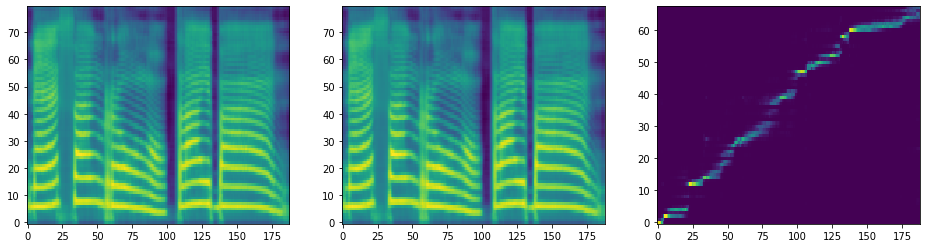

In [ ]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)